## 2. Feature extraction

### References:
1. https://github.com/ypwhs/dogs_vs_cats
2. https://www.kaggle.com/yangpeiwen/keras-inception-xception-0-47

### Import pkgs

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
# from keras.preprocessing import image
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D
# from keras import backend as K

# from keras.layers import Input
# from keras.layers.core import Lambda

# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg19 import VGG19
# from keras.applications.resnet50 import ResNet50
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.xception import Xception
# from keras.applications.inception_resnet_v2 import InceptionResNetV2


from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

### Load data

In [3]:
cwd = os.getcwd()
df = pd.read_csv(os.path.join(cwd, 'input', 'labels.csv'))
print('lables amount: %d' %len(df))
df.head()

lables amount: 10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

In [5]:
width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('.\\input\\train\\%s.jpg' % df['id'][i]), (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

100%|████████████████████████████████████████████████████████████████████| 10222/10222 [00:55<00:00, 182.98it/s]


### Preview images

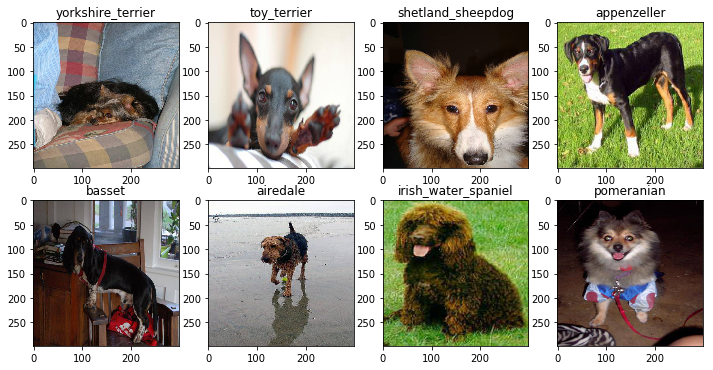

In [6]:
plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(num_to_class[y[random_index].argmax()])
plt.show()

### Export feature

In [7]:
def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [9]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features = np.concatenate([inception_features, xception_features], axis=-1)

10222/10222 [==============================]===>.] - ETA: 4646 - ETA: 2349 - ETA: 1889 - ETA: 1692 - ETA: 1295 - ETA: 1109 - ETA: 951 - ETA: 76 - ETA: 58 - ETA: 48 - ETA: 41 - ETA: 33 - ETA: 34 - ETA: 28 - ETA: 29 - ETA: 24 - ETA: 25 - ETA: 21 - ETA: 22 - ETA: 18 - ETA: 19 - ETA: 16 - ETA: 16 - ETA: 14 - ETA: 14 - ETA: 12 - ETA: 12 - ETA: 10 - ETA: 10 - ETA: 94s - ETA: 95 - ETA: 82 - ETA: 83 - ETA: 72 - ETA: 72 - ETA: 62 - ETA: 62 - ETA: 63 - ETA: 55 - ETA: 53 - ETA: 54 - ETA: 48 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 42 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 35 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA

### Train model

In [10]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=10, validation_split=0.1, verbose=2)

Train on 9199 samples, validate on 1023 samples
Epoch 1/10
2s - loss: 1.8960 - acc: 0.5933 - val_loss: 0.6966 - val_acc: 0.8055
Epoch 2/10
0s - loss: 0.5880 - acc: 0.8356 - val_loss: 0.5382 - val_acc: 0.8387
Epoch 3/10
0s - loss: 0.4436 - acc: 0.8728 - val_loss: 0.5069 - val_acc: 0.8475
Epoch 4/10
0s - loss: 0.3631 - acc: 0.8912 - val_loss: 0.4675 - val_acc: 0.8553
Epoch 5/10
0s - loss: 0.3007 - acc: 0.9119 - val_loss: 0.4725 - val_acc: 0.8514
Epoch 6/10
0s - loss: 0.2578 - acc: 0.9300 - val_loss: 0.4624 - val_acc: 0.8543
Epoch 7/10
0s - loss: 0.2260 - acc: 0.9403 - val_loss: 0.4537 - val_acc: 0.8534
Epoch 8/10
0s - loss: 0.2018 - acc: 0.9477 - val_loss: 0.4589 - val_acc: 0.8543
Epoch 9/10
0s - loss: 0.1785 - acc: 0.9513 - val_loss: 0.4427 - val_acc: 0.8631
Epoch 10/10
0s - loss: 0.1579 - acc: 0.9587 - val_loss: 0.4470 - val_acc: 0.8602


### Visualize model

In [11]:
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Virtualize train curve

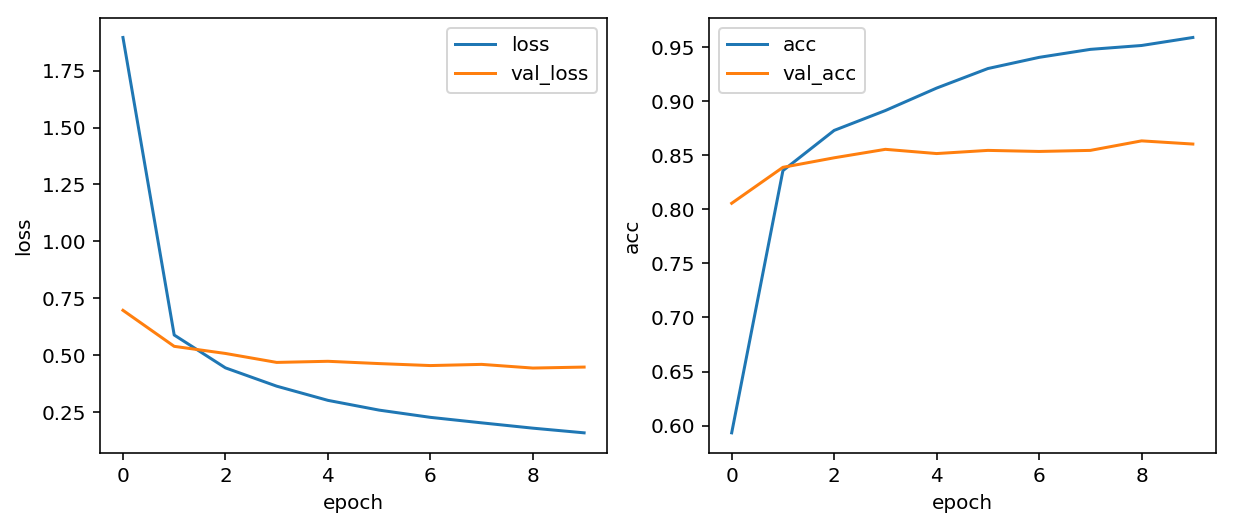

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

### Load test data

In [13]:
df2 = pd.read_csv('.\\input\\sample_submission.csv')
n_test = len(df2)
X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread('.\\input\\test\\%s.jpg' % df2['id'][i]), (width, width))

100%|█████████████████████████████████████████████████████████████████████| 10357/10357 [05:20<00:00, 32.35it/s]


### Export test data feature

In [14]:
inception_features = get_features(InceptionV3, X_test)
xception_features = get_features(Xception, X_test)
features_test = np.concatenate([inception_features, xception_features], axis=-1)

10357/10357 [==============================] - ETA: 77 - ETA: 51 - ETA: 41 - ETA: 36 - ETA: 33 - ETA: 31 - ETA: 29 - ETA: 28 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 99s - ETA: 98 - ETA: 96 - ETA: 95 - ET

### Get test data prediction and output

In [15]:
y_pred = model.predict(features_test, batch_size=128)
for b in breed:
    df2[b] = y_pred[:,class_to_num[b]]
df2.to_csv('.\\output\\pred.csv', index=None)

In [16]:
print('Done !')

Done !
